In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json


In [2]:
import utils_generic as generic
import multitask_simple as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)
tasks = ['to','as','about']

In [4]:
model_conf = confs.distilbert_conf

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset(convai_train,tasks,model_conf) 
convai_val_token = generic.tokenize_dataset(convai_val,tasks,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultiTaskSimple(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultiTaskSimple(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset(md_data,tasks,model_conf) 
md_dataset = mt.DatasetMultiTaskSimple(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [11]:
model = mt.MultiTaskSimple(model_conf).to(device)
save_path='m1_distilbert_multi'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.5189393939393939, 'as': 0.516297262059974, 'about': 0.4885204081632653}
Accuracy evaluando en etiquetas female
{'to': 0.0, 'as': 0.0, 'about': 0.0}
Accuracy evaluando en etiquetas male
{'to': 1.0, 'as': 1.0, 'about': 0.9973958333333334}


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.079034400733921 	 Validation loss: 2.080376592733092 	 
  1%|          | 574/57400 [01:53<3:05:16,  5.11it/s]
Epoch 2 	 Training loss: 2.069307878873074 	 Validation loss: 2.065265081696591 	 
  2%|▏         | 1148/57400 [03:54<3:15:32,  4.79it/s]
Epoch 3 	 Training loss: 2.0483819825724026 	 Validation loss: 2.040248551611173 	 
  3%|▎         | 1722/57400 [06:22<6:30:37,  2.38it/s]
Epoch 4 	 Training loss: 2.0198208797684116 	 Validation loss: 2.0166282613398665 	 
  4%|▍         | 2296/57400 [09:47<3:28:50,  4.40it/s]
Epoch 5 	 Training loss: 2.0030763275947305 	 Validation loss: 2.0084483340635138 	 
  5%|▌         | 2870/57400 [11:52<2:52:36,  5.27it/s]
Epoch 6 	 Training loss: 1.9948368471258608 	 Validation loss: 2.0123018612295893 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [13:46<2:51:25,  5.25it/s]
Epoch 7 	 Training loss: 1.9905442956848012 	 Validation loss: 1.988166784836074 	 
  7%|▋         | 4018/57400 [15:39<2:47:22,  5.32it/s

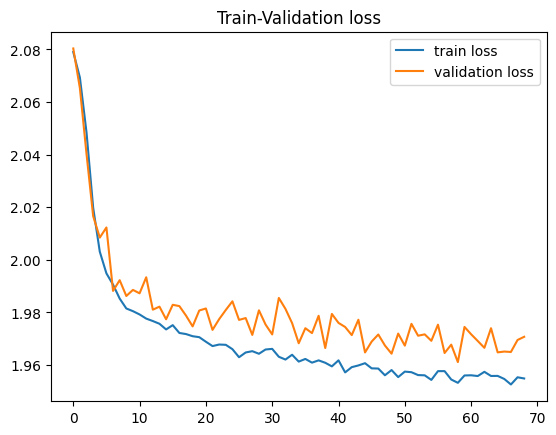

In [13]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [14]:
model = mt.MultiTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy evaluando en todas las etiquetas
{'to': 0.6679292929292929, 'as': 0.7196870925684485, 'about': 0.8418367346938775}
Accuracy evaluando en etiquetas female
{'to': 0.6509186351706037, 'as': 0.7493261455525606, 'about': 0.85}
Accuracy evaluando en etiquetas male
{'to': 0.683698296836983, 'as': 0.6919191919191919, 'about': 0.8333333333333334}


In [17]:
del model
torch.cuda.empty_cache()

In [ ]:
model = mt.MultiTaskSimple(model_conf).to(device)
save_path='m1_distilbert_multi-adamw'
learning_rate = 0.001
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [ ]:
model = mt.MultiTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))